# DL FOR HAR USING WI-FI CSI 
#### JESSICA ROA - S219604321

In [1]:
import os
import numpy as np
import pandas as pd
import pywt
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, accuracy_score, ConfusionMatrixDisplay, precision_score, recall_score
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import cross_val_predict
from sklearn import preprocessing

In [2]:
# loading the data into a dataframe with its labels
dataset_path = 'Room2_npy'

data_list = []
labels_list = []

for activity_folder in os.listdir(dataset_path):
    activity_path = os.path.join(dataset_path, activity_folder)

    if os.path.isdir(activity_path):
        for participant_file in os.listdir(activity_path):
            participant_path = os.path.join(activity_path, participant_file)

            if os.path.isfile(participant_path) and participant_file.endswith('.npy'):
                data = np.load(participant_path)
                data_list.append(data)
                labels_list.append(activity_folder)

# Convertint lists to a Pandas DataFrame
df = pd.DataFrame({'Data': data_list, 'Label': labels_list})
print(df.head())

                                                Data  Label
0  [[(35+9j), (45.60943+12.991533j), (55.21296+18...  kneel
1  [[(-33+5j), (-44.12291+6.1781054j), (-54.80163...  kneel
2  [[(33+13j), (42.481213+16.411777j), (50.40207+...  kneel
3  [[(33+13j), (42.481213+16.411777j), (50.40207+...  kneel
4  [[(9-22j), (10.663341-27.409727j), (12.641799-...  kneel


In [3]:
#extracting the real part 
df['Data'] = df['Data'].apply(lambda x: np.real(x))
print(df.head())

                                                Data  Label
0  [[35.0, 45.60943, 55.21296, 63.100838, 71.2392...  kneel
1  [[-33.0, -44.12291, -54.801636, -62.216095, -6...  kneel
2  [[33.0, 42.481213, 50.40207, 57.23787, 62.3720...  kneel
3  [[33.0, 42.481213, 50.40207, 57.23787, 62.3720...  kneel
4  [[9.0, 10.663341, 12.641799, 11.59478, 11.7531...  kneel


In [4]:
#Wavelet denoise

def wavelet_denoise(data, wavelet='db1', level=3):
    coeffs = pywt.wavedec(data, wavelet, level=level)
    coeffs[1:] = (pywt.threshold(c, value=np.std(c) / 2, mode="soft") for c in coeffs[1:])
    return pywt.waverec(coeffs, wavelet)

df['Denoised_Data'] = df['Data'].apply(lambda x: wavelet_denoise(x))
print(df.head())

                                                Data  Label  \
0  [[35.0, 45.60943, 55.21296, 63.100838, 71.2392...  kneel   
1  [[-33.0, -44.12291, -54.801636, -62.216095, -6...  kneel   
2  [[33.0, 42.481213, 50.40207, 57.23787, 62.3720...  kneel   
3  [[33.0, 42.481213, 50.40207, 57.23787, 62.3720...  kneel   
4  [[9.0, 10.663341, 12.641799, 11.59478, 11.7531...  kneel   

                                       Denoised_Data  
0  [[43.52499, 51.728146, 58.50724, 63.988846, 70...  
1  [[-42.07321, -50.8004, -58.458168, -63.476913,...  
2  [[41.11456, 48.34361, 53.593952, 58.177586, 61...  
3  [[41.11456, 48.34361, 53.593952, 58.177586, 61...  
4  [[10.966344, 10.966344, 10.966344, 10.966344, ...  


In [5]:
#Ensuring the data has the same lenght (all participants (7500, 90))

target_shape = (7500, 90)
df['Denoised_Data'] = df['Denoised_Data'].apply(lambda x: x[:target_shape[0], :target_shape[1]])

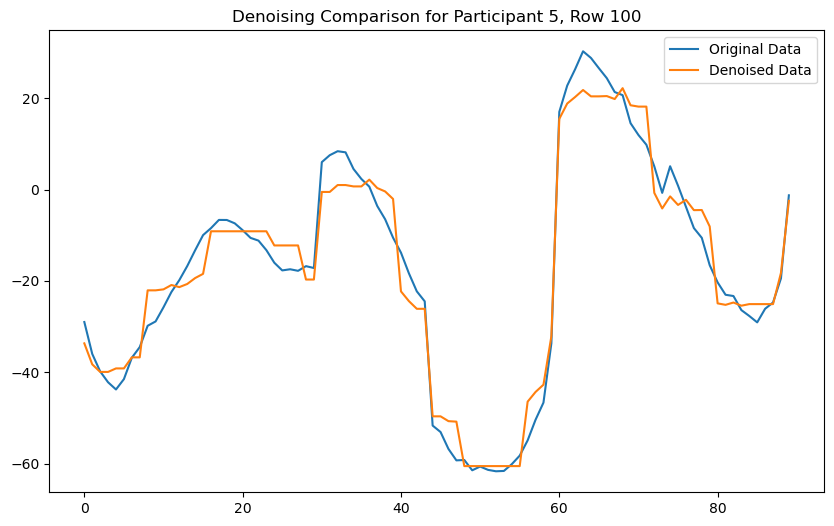

In [6]:
#Plot of one participant to see the denoised data
participant_index = 5
row_number = 100  

original_data = df['Data'][participant_index][row_number, :]
denoised_data = df['Denoised_Data'][participant_index][row_number, :]

plt.figure(figsize=(10, 6))
plt.plot(original_data, label='Original Data')
plt.plot(denoised_data, label='Denoised Data')
plt.legend()
plt.title(f'Denoising Comparison for Participant {participant_index}, Row {row_number}')
plt.show()